Saved figures\slither_findings.png figures\slither_findings.svg


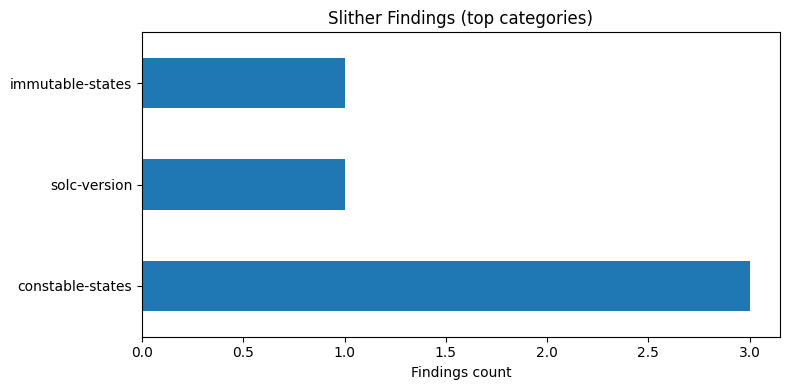

In [ ]:
# scripts/plot_slither_summary.py
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

json_path = "web3-copilot-extension/slither-output.json"  # update if necessary
out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)

with open(json_path, 'r', encoding='utf8') as f:
    data = json.load(f)

# Slither JSON format varies; a common structure: data['results']['detectors'] or data['detectors']
# Try to locate issues list:
issues = []
if 'results' in data and 'detectors' in data['results']:
    detectors = data['results']['detectors']
    for d in detectors:
        name = d.get('name') or d.get('check')
        issues.append(name)
elif isinstance(data, dict):
    # fallback gather messages
    def gather(obj):
        if isinstance(obj, dict):
            for k,v in obj.items():
                gather(v)
        elif isinstance(obj, list):
            for item in obj:
                gather(item)
        else:
            pass
    # naive approach: look for 'check' keys with names:
    names = []
    def collect_names(obj):
        if isinstance(obj, dict):
            if 'check' in obj and isinstance(obj['check'], str):
                names.append(obj['check'])
            for v in obj.values():
                collect_names(v)
        elif isinstance(obj, list):
            for it in obj:
                collect_names(it)
    collect_names(data)
    issues = names

# Count occurrences by issue name
from collections import Counter
counts = Counter(issues)

# Fallback: if counts empty, inspect any 'issues' key
if not counts and 'issues' in data:
    counts = Counter([i.get('check', 'unknown') for i in data['issues']])

if not counts:
    print("No issues parsed from Slither JSON. Inspect file manually.")
else:
    df = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).sort_values('count', ascending=False)
    df = df.head(10)  # top 10
    fig, ax = plt.subplots(figsize=(8,4))
    df['count'].plot(kind='barh', ax=ax)
    ax.set_xlabel('Findings count')
    ax.set_title('Slither Findings (top categories)')
    plt.tight_layout()
    out_png = os.path.join(out_dir, "slither_findings.png")
    out_svg = os.path.join(out_dir, "slither_findings.svg")
    plt.savefig(out_png, dpi=300)
    plt.savefig(out_svg)
    print("Saved", out_png, out_svg)
